In [1]:
import numpy as np
import seaborn as sb
import json
import pandas as pd
import nltk
from nltk.tokenize import TreebankWordTokenizer,sent_tokenize
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import re, pickle
from tokenizers import ByteLevelBPETokenizer
import contractions as con
import string

tk = TreebankWordTokenizer()

In [2]:
# load only the required data
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
def clean_text(text):
    # Create a translation table that maps all punctuation characters to spaces
    text = [con.fix(w) for w in text.split()]
    text = ' '.join(text).lower()
    translation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    
    # remove url
    url_pattern = r'http\S+|www\S+'
    text = re.sub(url_pattern, '', text)
    
    # Use the translate method to replace punctuation with spaces
    result_string = text.translate(translation_table)
    
    # remove punctuations
    text = re.sub(r'\s+', ' ', result_string)
    text = tk.tokenize(text)
    text = [w for w in text if w.isalpha()]
    text = ' '.join(text)
    return text


In [4]:
df.review = df.review.apply(lambda x: x.replace('<br />',' '))

In [5]:
i = np.random.randint(0,49000)

print(df.review[i])
print()
clean_text(df.review[i])

Ann-Margret did the best job she has ever done in her history of film making. I felt as if she WAS Mrs. Frey. There might be one or two films of Ann-Margret's I have not seen since her film debut in "Pocket full of Miracles" with Betty Davis in 1961. I feel she has been totally under-rated in the industry. Though she was nominated for an Emmy Award for this role in "Who Will Love My Children," she was overlooked. Like she was nominated for an Academy Award for her roles in "Carnal Knowledge" and "Tommy," she was snubbed. Over all, I think everyone did a superb acting job including all the children in "Who Will Love My Children." Yes, it is a sad movie (as true stories can be), but well worth the time. Thank you.



'ann margret did the best job she has ever done in her history of film making i felt as if she was mrs frey there might be one or two films of ann margret s i have not seen since her film debut in pocket full of miracles with betty davis in i feel she has been totally under rated in the industry though she was nominated for an emmy award for this role in who will love my children she was overlooked like she was nominated for an academy award for her roles in carnal knowledge and tommy she was snubbed over all i think everyone did a superb acting job including all the children in who will love my children yes it is a sad movie as true stories can be but well worth the time thank you'

In [6]:
# segregate sentences from each sample and clean text
df['sentences'] = df.review.apply(lambda x: sent_tokenize(x))
df['sentences'] = df.sentences.apply(lambda x: [clean_text(sent) for sent in x])
df['clean_text'] = df.sentences.apply(lambda x: ' '.join(x))


<AxesSubplot: >

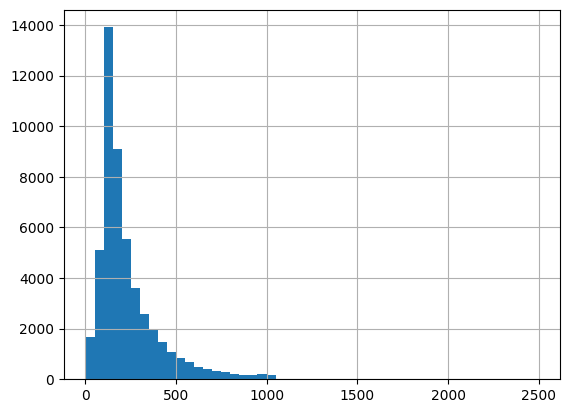

In [7]:
# word count distribution
df.clean_text.apply(lambda x: len(x.split())).hist(bins=50)

<AxesSubplot: >

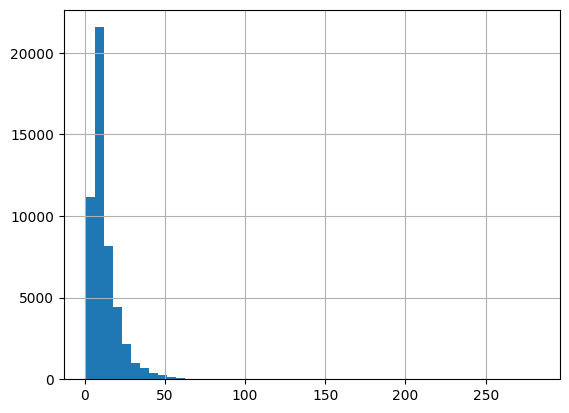

In [8]:
# sentence count distribution
df.sentences.apply(lambda x: len(x)).hist(bins=50)

In [9]:
# get samples with atleast 100 words
minlen = 100
df['word_count'] = df.clean_text.apply(lambda x: len(x.split()))
data = df[df.word_count >= minlen].copy()
data = data.reset_index(drop=True)
len(data)/len(df)

0.8807

In [10]:
# vocabulary class

class Vocabulary:
    def __init__(self):
        self.special_toks = ['<pad>','<mask>','<unk>','<cls>','<sep>']
        self.w2i = {'<pad>':0,'<sep>':2,'<mask>':1,'<unk>':3,'<cls>':4}
        self.i2w = {self.w2i[k]:k for k in self.w2i}
        self.size = len(self.special_toks)
        self.wc = {}
        
    def __call__(self,text):
        
        for sent in text:
            words = sent.split()
            for w in words:
                if w not in self.w2i and w not in self.special_toks:
                    self.w2i[w] = self.size
                    self.i2w[self.size] = w
                    self.size += 1
                    
                    self.wc[w] = 1
                    
                else:
                    self.wc[w] += 1
                    
        self.wc = dict(sorted(self.wc.items(), key=lambda x: x[1], reverse=True))
        
    def tokenize(self,seq):
        seq = seq.split()
        for i,w in enumerate(seq):
            if w not in self.wc:
                seq[i] = 3
            else:
                seq[i] = self.w2i[w]
                
        return seq
                
    def add_padding(self,seq,maxlen):
        padding = [0]*(maxlen - len(seq))
        return seq + padding
        
        

In [11]:
# create sample for train and test
# min input sequence length is will be 100 and max will be 200

def split_long_text(text,minlen=100,maxlen=200):
    splitted_text = []
    if len(text.split()) > maxlen:
        seq = text.split()
        n_div = len(seq) // maxlen + 1
        for i in range(n_div):
            tmp = seq[i*maxlen:(i+1)*maxlen]
            if len(tmp) >= minlen:
                splitted_text.append(tmp)
    elif maxlen >= len(text.split()) >= minlen:
        splitted_text.append(text.split())
                
    return splitted_text

text_data = []

for text in data.clean_text:
    splitted_text = split_long_text(text)
    text_data.extend(splitted_text)
    
text_data = [' '.join(x).replace(' s ',' ') for x in text_data]

np.random.shuffle(text_data)

# create vocabulary
vocab = Vocabulary()
vocab(text_data)
vocab.wc
print('vocabulary size :',vocab.size,'words')
print('number of sequences :',len(text_data))

vocabulary size : 95935 words
number of sequences : 61704


In [12]:
# tokenize sequences
token_seq = [vocab.tokenize(x) for x in text_data]
maxlen = max([len(x) for x in token_seq])

In [13]:
# create sentence pairs

sent_pairs = []

for seq in token_seq:
    if len(token_seq) <= maxlen - 3:
        s1 = [4]+seq[:len(seq)//2]+[2]
        s2 = seq[len(seq)//2:]+[2]
    else:
        seq[0] = vocab.w2i['<cls>']
        seq[len(seq)//2] = 2
        s1 = seq[:len(seq)//2 + 1]
        seq[-1] = 2
        s2 = seq[len(seq)//2 + 1:]
    sent_pairs.append((s1,s2))    
    
random.shuffle(sent_pairs)

In [14]:
# segregate sentence pairs "next" and "not next"
 
is_next = sent_pairs[:len(sent_pairs)//2]
is_next = [(x[0]+x[1],1) for x in is_next]

not_next = sent_pairs[len(sent_pairs)//2:]
not_next0 = [x[0] for x in not_next]
not_next1 = [x[1] for x in not_next]
random.shuffle(not_next1)
not_next = [(not_next0[i]+not_next1[i],0) for i in range(len(not_next))]

i = np.random.randint(0,len(is_next))
print(' '.join([vocab.i2w[x] for x in is_next[i][0] if x>0]))
print()
print(' '.join([vocab.i2w[x] for x in not_next[i][0] if x>0]))

<cls> vastly underrated black comedy the finest in a series of grand guignol movies to follow baby jane reynolds and winters are mothers of young convicted murderers a nod to compulsion who run away to hide in hollywood they run a school for would be movie tots a bunch of hilariously untalented kids attended by awful stage moms debbie in her blonde wig i am a harlow you are more a marion davies she tells winters leads the tots <sep> their concert and wins a rich dad weaver she also does a deliciously funny tango and over all gives an outstanding performance unlike anything she would done before the atmosphere is a fine mix of comic and eerie it looks wonderful with great period detail lots of lovely swipes at hollywood and the terrifying movie tot micheal macliammoir has a ball as the drama coach hamilton starr he purrs two r but prophetic nonetheless see it and love <sep>

<cls> did not catch gilmore girls when it first came out so still doing some catch up on the first season i read 

In [15]:
# create segments for sentence

def create_segments(x,maxlen=200):
    seq,out = x
    seq = vocab.add_padding(seq,maxlen)
    assert maxlen >= len(seq)
    seq = np.asarray(seq)
    seg = np.zeros(seq.shape,dtype=np.int32)
    sep_idx = np.where(seq == 2)[0]
    seg[sep_idx[0]+1:sep_idx[1]+1] = 1
    return seq,seg,out

create_segments(not_next[1],maxlen=maxlen)   

(array([    4,   298,   197,   251,   440, 27346,   200,    34,   865,
        27346,    92, 11132,   219,   206,   174,   128,   551,    92,
          108,  1564,   291, 13302,    95, 10213,   393,    20,  1183,
          144,   143,    40,  1129,  1130,    92,   190,    40,   113,
         5636,   291,   321,    20,   321,   225,    13,    14,  1294,
           23,  2594,   149,   587,   437,     5,   324,  6693,  8556,
        15199,   144,   189,     2,   230,    23,    40,  3491,   156,
          157, 10968, 18500,   170,   197,   455,  2000,    95,   159,
          171,  1644,   149,   150,   159,   455,   152,    25,    22,
          452,   185,    69,   113,   460,   150,  2401,     6,   403,
           18,     6,   551,   807,   533,   236,  1762,   682,   270,
           18,   381,    14,  4409,  3872,   225,   200,   216,   159,
         1200,   372,  4928,   161,   162,   202,   253,     6,  2124,
         2912,   270,   237,    14,  9060,   232,     6,  2036,   408,
      

In [16]:
is_next = [create_segments(x,maxlen) for x in is_next]
not_next = [create_segments(x,maxlen) for x in not_next]

In [17]:
# don't mask most frequent stopwords (for MLM)

with open('D:/stop_words_english.txt','r',encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [w.replace('\n','') for w in stopwords]

def get_dont_mask_tokens(word_count,stopwords,word2idx):
    tokens = [vocab.w2i['<sep>'],vocab.w2i['<pad>'],vocab.w2i['<cls>']]
    count = 0
    for x in word_count:
        if x not in stopwords:
            break
        tokens.append(word2idx[x])
        count += 1
        
    return np.asarray(tokens,np.int32)

dont_mask_tokens = get_dont_mask_tokens(vocab.wc,stopwords,vocab.w2i)
', '.join([vocab.i2w[t] for t in dont_mask_tokens])

'<sep>, <pad>, <cls>, the, and, a, of, is, to, in, it, i, this, that, not, was, as, with, for'

In [18]:
def create_masked_data(seq,vocab_size,for_train=True,dont_mask_toks=np.asarray([2,0,4],np.int32)):
    
    # mask random tokens
    seq = np.asarray(seq,dtype=np.int32)
    masked_seq = seq.copy()
    n_mask = int(len(np.where(seq>0)[0])*0.13)
    mask = ~np.isin(seq, dont_mask_toks)
    to_mask_idx = np.where(mask)[0]
    to_mask_prob = n_mask/len(to_mask_idx)
    probs = np.linspace(0,1,len(to_mask_idx))
    np.random.shuffle(probs)
    to_mask = masked_seq[to_mask_idx].copy()
    to_mask = np.where(probs>=to_mask_prob,to_mask,1)
    masked_seq[to_mask_idx] = to_mask
    masked_idx = np.where(masked_seq == 1)[0]
    
    # create inverse mask
    inv_mask = np.zeros(len(seq),dtype=np.int32)
    inv_mask[masked_idx] = seq[masked_idx]
    
    # replace 1% of tokens with random tokens (only for training data) 
    if for_train:
        non_masked_idx = np.where(masked_seq > 1)[0]
        num_tok_to_replace = int(len(seq) * 0.01 + 1)
        rand_idx = non_masked_idx[np.random.randint(0,len(non_masked_idx)-1,2)]
        rand_replacements = np.random.randint(5,vocab_size,2)
        masked_seq[rand_idx] = rand_replacements
        
    return seq,masked_seq,inv_mask

i = np.random.randint(0,len(token_seq)//2-1)
create_masked_data(not_next[i][0],vocab.size,for_train=True,dont_mask_toks=dont_mask_tokens)

(array([    4,  2830,     6,   322,  3049,   206,  2205,   149,   170,
          171,  4310,   232,   144,   189,    69,   200,    34,   455,
          437,  2405,   189,     6,   209,   321,   396,   544,     6,
         6279,    34,   232,   187,     6,   403,    18,     6,   189,
           34,   651,  1273,     6,   407,    34,   543,     6,   529,
           47,     6,   938,  1627,  2275,   279,   938,     6,   938,
          356,   159,   357,    20,   434,    22,    40,  2657,   322,
           13,  1673,     6,  6279,   180,   183,    13,  2290,  5929,
           90,    13,   190,   159,  1426,   379,    20,   190,     5,
          200,   180,   183,    95,   143,  1118,    20,  2070,   200,
          280,     6,  1063,   198,    13,  1673,   200,    90,     6,
         1840,     2,   107,   232,   437,  1186,    95,  4614,   187,
          181,   378,   183,   495,   206,   329,     6,  2781,    95,
         1760,    58,  1399,   270,    18,   318,  1703,   144,    34,
      

In [19]:
s,mlm_x,mlm_y = create_masked_data(not_next[i][0],vocab.size,for_train=True,dont_mask_toks=dont_mask_tokens)
mlm_y_idx = np.where(mlm_y>0)[0]
print(' '.join([vocab.i2w[x] for x in s if x>0]))
print()
print(' '.join([vocab.i2w[x] for x in mlm_x if x>0]))
print()
print(' '.join([vocab.i2w[x] for x in mlm_y[mlm_y_idx]]))

<cls> reading the first reviews on imdb i was very enthusiastic about this movie but it is really an awful movie the total time you see the alien is about minutes the rest of the movie is cheap suspense the acting is over the top en the story oh boy which story the story does not seem to go in a direction first they capture the alien after years they finally succeed then they do not know what to do with it after years and even want to release it why the hell did they capture it then the girlfriend <sep> only about an hour and twelve minutes all these years later on tv the tension and drama has lost most of its impact this is still a good movie as far as early standards go along with ford are anne vernon and maurice denham the villain saboteur is played by victor <sep>

<cls> reading the first reviews <mask> imdb i was very enthusiastic about this movie but it is <mask> an awful <mask> the <mask> time you see the <mask> is about minutes the rest of the movie is <mask> suspense the <mask

In [20]:
np.random.shuffle(is_next)
np.random.shuffle(not_next)   

In [21]:
pretraining_data = {'train':{'seq':[],'masked_seq':[],'segment_ids':[],'inv_mask':[],'is_next':[]},
                    'valid':{'seq':[],'masked_seq':[],'segment_ids':[],'inv_mask':[],'is_next':[]}}

In [22]:
# split train and test

train,valid = [],[]

val_size = 2000//2

for i in range(len(is_next)):
    
    if i >= val_size:
        seq,seg,out = is_next[i]
        seq,masked_seq,inv_mask = create_masked_data(seq,vocab.size,for_train=True,dont_mask_toks=dont_mask_tokens)
        train.append((seq,masked_seq,seg,inv_mask,out))
        
        seq,seg,out = not_next[i]
        seq,masked_seq,inv_mask = create_masked_data(seq,vocab.size,for_train=True,dont_mask_toks=dont_mask_tokens)
        train.append((seq,masked_seq,seg,inv_mask,out))
        
    else:
        seq,seg,out = is_next[i]
        seq,masked_seq,inv_mask = create_masked_data(seq,vocab.size,for_train=False,dont_mask_toks=dont_mask_tokens)
        valid.append((seq,masked_seq,seg,inv_mask,out))
        
        seq,seg,out = not_next[i]
        seq,masked_seq,inv_mask = create_masked_data(seq,vocab.size,for_train=False,dont_mask_toks=dont_mask_tokens)
        valid.append((seq,masked_seq,seg,inv_mask,out))
        

In [23]:
np.random.shuffle(train)
np.random.shuffle(valid)   

len(train),len(valid)

(59704, 2000)

In [24]:
for i in range(len(train)):
    x = train[i]
    j = 0
    for k in pretraining_data['train']:
        pretraining_data['train'][k].append(x[j])
        j += 1
        
for i in range(len(valid)):
    x = valid[i]
    j = 0
    for k in pretraining_data['valid']:
        pretraining_data['valid'][k].append(x[j])
        j += 1

In [25]:
# save MLM data, NSP data and vocabulary

with open('pretraining data.pkl','wb') as f:
    pickle.dump(pretraining_data,f)
    
with open('vocab.pkl','wb') as f:
    pickle.dump(vocab,f)